#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
        * 각 모델의 성능을 관리하는 별도의 엑셀파일을 만들어 봅시다.
        * 성능 가이드 : Accuracy 0.900 ~

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

In [9]:
import sklearn
print(sklearn.__version__)

1.4.2


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import joblib

# 필요한 라이브러리, 함수 로딩 ------------------




* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [12]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [16]:
data = pd.read_csv('data01_train.csv')
data.drop(columns='subject', inplace=True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [17]:
test_data = pd.read_csv('data01_test.csv')
test_data.drop(columns='subject', inplace=True)
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


#### 2) 기본 정보 조회

In [19]:
data.shape

(5881, 562)

In [20]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [24]:
target = 'Activity'

x = data.drop(columns=[target])
y = data.loc[:, target]

### (2) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y, random_state=1)

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [30]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 5개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘 별로 다음 중 몇가지를 시도하며 성능을 비교한다.

### (1) 모델1

In [34]:
# 로지스틱회귀

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

model_Logistic = LogisticRegression()
model_Logistic.fit(x_train, y_train)
y_pred_Logistic = model_Logistic.predict(x_test)
print(confusion_matrix(y_test, y_pred_Logistic))
print(classification_report(y_test, y_pred_Logistic))

[[335   0   0   0   0   0]
 [  0 293  16   0   0   1]
 [  0  14 312   0   0   0]
 [  0   0   0 297   1   2]
 [  0   0   0   0 236   1]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.95      0.95      0.95       310
          STANDING       0.95      0.96      0.95       326
           WALKING       1.00      0.99      0.99       300
WALKING_DOWNSTAIRS       0.99      1.00      0.99       237
  WALKING_UPSTAIRS       0.98      0.99      0.99       257

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



In [36]:
# 회귀계수
print(model_Logistic.coef_.round(3))
print(model_Logistic.intercept_.round(3))

[[-0.073 -0.044  0.032 ...  1.294 -0.558 -0.168]
 [-0.078  0.047 -0.053 ... -0.498 -0.955 -0.166]
 [ 0.037 -0.038  0.04  ... -0.402  1.269  0.189]
 [ 0.022 -0.004  0.003 ... -0.244  0.026  0.068]
 [ 0.182  0.096  0.114 ... -0.37  -0.217 -0.112]
 [-0.09  -0.057 -0.136 ...  0.22   0.435  0.189]]
[-0.013 -0.125 -0.118  0.098  0.118  0.04 ]


In [37]:
# z 값 확인 
z = model_Logistic.decision_function(x_test)
print(z[:10])

[[ -6.54216671  -6.72343538  -0.62526339   9.31157768  -0.5022863
    5.0815741 ]
 [ -6.26823558  -2.15847293  -2.03651632  -1.0919016    4.18093596
    7.37419048]
 [ -0.69173736   3.65511318   5.73803365   2.06390533  -6.21516666
   -4.55014813]
 [ -1.03062373   1.67778644   9.17424909   0.94798958  -7.98541091
   -2.78399047]
 [ 17.2513336   11.02848844  -1.83705903  -8.57012995  -8.16371109
   -9.70892196]
 [  3.86325938  13.01917457   7.83271106  -3.31731785  -8.97524279
  -12.42258436]
 [  2.17083268  10.36613041   8.15860255  -4.00527926  -9.00037224
   -7.68991415]
 [ -9.06649298 -11.32624507  -1.1631234    4.61652872  11.79381899
    5.14551374]
 [ -5.01134447  -5.11064551  -1.88663374   0.4861908    1.1885734
   10.33385952]
 [ -6.82588619  -5.55488612  -1.14639939   3.00853517   9.29145618
    1.22718036]]


In [38]:
# 로지스틱 함수 사용
from scipy.special import expit
print(expit(z)[:10].round(3))

[[0.001 0.001 0.349 1.    0.377 0.994]
 [0.002 0.104 0.115 0.251 0.985 0.999]
 [0.334 0.975 0.997 0.887 0.002 0.01 ]
 [0.263 0.843 1.    0.721 0.    0.058]
 [1.    1.    0.137 0.    0.    0.   ]
 [0.979 1.    1.    0.035 0.    0.   ]
 [0.898 1.    1.    0.018 0.    0.   ]
 [0.    0.    0.238 0.99  1.    0.994]
 [0.007 0.006 0.132 0.619 0.766 1.   ]
 [0.001 0.004 0.241 0.953 1.    0.773]]


In [39]:
# y_pred 값 확인 
print(y_pred_Logistic[:10])

['WALKING' 'WALKING_UPSTAIRS' 'STANDING' 'STANDING' 'LAYING' 'SITTING'
 'SITTING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS']


In [40]:
# 확률값 확인
p = model_Logistic.predict_proba(x_test)
p1 = p[:,1]
print(p1[:10].round(3))

[0.    0.    0.108 0.001 0.002 0.994 0.901 0.    0.    0.   ]


### (2) 모델2

In [42]:
# Decision Tree - Grid Search

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

model_DT_RS = DecisionTreeClassifier(random_state=1)

# 성능예측
cv_score = cross_val_score(model_DT_RS, x_train, y_train, cv=5)

print(cv_score)
print('평균:', cv_score.mean())

[0.93567961 0.93438639 0.91737546 0.91494532 0.91737546]
평균: 0.9239524472389672


In [44]:
# 튜닝
# 파라미터 선언
  # max_depth: range(1, 51)
params = {'max_depth': range(1, 11)}

# Grid Search 선언
  # cv=5
  # scoring='accuracy'
model_DT_RS = GridSearchCV(model_DT_RS,             # 기본 모델 이름
                     params,               # 앞에서 선언한 튜닝용 파라미터 변수
                     cv=5,                 # k-fold Cross Validation(default=5)
                     scoring='accuracy')   # 평가 방법
model_DT_RS.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': range(1, 11)}, scoring='accuracy')

In [45]:
model_DT_RS.cv_results_['mean_test_score']

array([0.37439276, 0.54348878, 0.79154555, 0.89066964, 0.89941636,
       0.9149639 , 0.92419517, 0.93075623, 0.92735404, 0.92492539])

In [46]:
# 최적 파라미터
model_DT_RS.best_params_

{'max_depth': 8}

In [47]:
# 최고 성능
model_DT_RS.best_score_

0.930756231641284

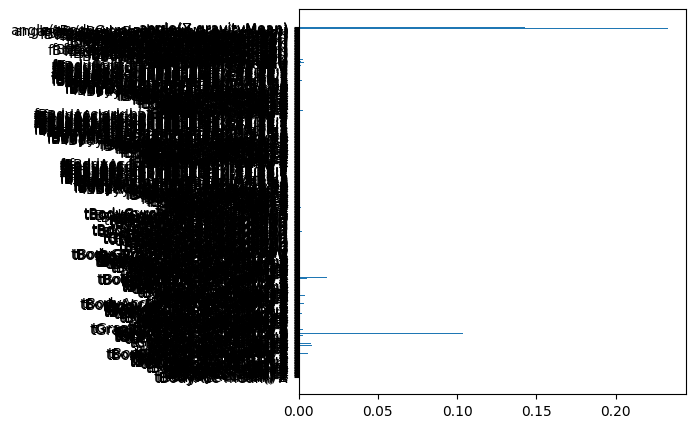

In [48]:
# 변수 중요도 시각화
plt.figure(figsize=(5, 5))
plt.barh(y=list(x), width=model_DT_RS.best_estimator_.feature_importances_)
plt.show()

In [49]:
# 성능 평가 
y_pred_2 = model_DT_RS.predict(x_test)
print(confusion_matrix(y_test, y_pred_2))
print(classification_report(y_test, y_pred_2))

[[335   0   0   0   0   0]
 [  0 280  29   0   0   1]
 [  0  23 303   0   0   0]
 [  0   0   0 284  11   5]
 [  0   0   0  10 221   6]
 [  0   0   1  15   5 236]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.92      0.90      0.91       310
          STANDING       0.91      0.93      0.92       326
           WALKING       0.92      0.95      0.93       300
WALKING_DOWNSTAIRS       0.93      0.93      0.93       237
  WALKING_UPSTAIRS       0.95      0.92      0.93       257

          accuracy                           0.94      1765
         macro avg       0.94      0.94      0.94      1765
      weighted avg       0.94      0.94      0.94      1765



In [50]:
model_DT_RS = DecisionTreeClassifier(random_state=1, max_depth=8)

# 성능예측
cv_score = cross_val_score(model_DT_RS, x_train, y_train, cv=5)

print(cv_score)
print('평균:', cv_score.mean())

[0.9381068  0.94167679 0.92709599 0.92709599 0.91980559]
평균: 0.930756231641284


### (3) 모델3

In [52]:
# KNN - Grid Search
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# KNN 모델 생성 (K=5로 설정)
model_knn = KNeighborsClassifier(n_neighbors=5)

# 성능 예측 (5-겹 교차 검증)
cv_scores_knn = cross_val_score(model_knn, x_train_s, y_train, cv=5)

# 결과 출력
print(cv_scores_knn)
print('평균:', cv_scores_knn.mean())

[0.95509709 0.95747266 0.9671932  0.95747266 0.95139733]
평균: 0.9577265863700173


In [53]:
# 파라미터 선언
  # n_neighbors: range(3, 11)
params = {'n_neighbors': range(1, 11),
         'p' : [1,2],
         'weights':['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

# Grid Search 선언
  # cv=5
  # scoring='accuracy'
model_knn = GridSearchCV(model_knn,            # 기본 모델 이름
                     params,               # 앞에서 선언한 튜닝용 파라미터 변수
                     cv=5,                 # k-fold Cross Validation(default=5)
                     scoring='accuracy')   # 평가 방법

In [54]:
model_knn.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean', 'minkowski'],
                         'n_neighbors': range(1, 11), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [55]:
# mean_test_score 확인
model_knn.cv_results_['mean_test_score']

array([       nan, 0.97424678,        nan, 0.97424678,        nan,
       0.97424678,        nan, 0.97424678,        nan, 0.97521736,
              nan, 0.97521736,        nan, 0.9764339 ,        nan,
       0.9764339 ,        nan, 0.96987401,        nan, 0.96987401,
              nan, 0.97521942,        nan, 0.97521942,        nan,
       0.97084636,        nan, 0.97084636,        nan, 0.97181812,
              nan, 0.97181812,        nan, 0.96744506,        nan,
       0.96744506,        nan, 0.97108937,        nan, 0.97108937,
       0.95991105, 0.95991105, 0.95991105, 0.95991105, 0.9504353 ,
       0.95991105, 0.9504353 , 0.95991105, 0.96064127, 0.96137031,
       0.96064127, 0.96137031, 0.95602608, 0.9642847 , 0.95602608,
       0.9642847 , 0.95772659, 0.95821232, 0.95772659, 0.95821232,
       0.95723997, 0.96185604, 0.95723997, 0.96185604, 0.95481131,
       0.95481131, 0.95481131, 0.95481131, 0.95238206, 0.95772747,
       0.95238206, 0.95772747, 0.95141178, 0.95116876, 0.95141

In [56]:
model_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [57]:
model_knn.best_score_

0.9764338968254904

In [58]:
y_pred_knn = model_knn.predict(x_test_s)

### (4) 모델4

In [60]:
# SVM
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

model_svm = SVC(kernel='linear', C=1, random_state=1)
model_svm.fit(x_train_s, y_train)
y_pred_svm = model_svm.predict(x_test_s)
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

[[335   0   0   0   0   0]
 [  0 296  13   0   0   1]
 [  0  11 315   0   0   0]
 [  0   0   0 299   0   1]
 [  0   0   0   0 236   1]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.96      0.95      0.96       310
          STANDING       0.96      0.97      0.96       326
           WALKING       1.00      1.00      1.00       300
WALKING_DOWNSTAIRS       1.00      1.00      1.00       237
  WALKING_UPSTAIRS       0.99      0.99      0.99       257

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



### (5) 모델5

In [62]:
# # LGBM
# from lightgbm import LGBMClassifier
# #
# LGBMClassifier(learning_rate= 0.17, n_estimators= 41,verbose=-1)
# model4_1.fit(x_train_s, y_train)

# pred4_1=model4_1.predict(x_test_s)
# print(model4_1.get_params)
# print(accuracy_score(y_test, pred4_1))
# print(confusion_matrix(y_test, pred4_1))
# print(classification_report(y_test, pred4_1))

### (6) 모델6

In [64]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'random_state': [1]  
}

rf_model = RandomForestClassifier()

# GridSearchCV 
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid,
                               scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(x_train_s, y_train)  

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_


Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [65]:
# 검증 데이터로 성능 평가
from sklearn.metrics import accuracy_score
y_pred_rf = grid_search_rf.predict(x_test_s)
result = accuracy_score(y_test, y_pred_rf)

# 최적 하이퍼파라미터 및 성능 출력
print(f"\n===== Random Forest 성능 =====")
print(f"Best Params: {best_params_rf}")
print(f"Best Params: {best_score_rf}")


===== Random Forest 성능 =====
Best Params: {'max_depth': None, 'n_estimators': 100, 'random_state': 1}
Best Params: 0.9725477474076607


## 4.성능비교

* 세부 요구사항
    - 각 모델에 대해서 test 데이터로 성능 측정후 비교
    

In [68]:
# valid_performance= {"score": {'Logistic':accuracy_score(y_test, y_pred_Logistic),
#                     'DecisionTree' : accuracy_score(y_test, pred2),
#                     'RandomwForest1' : accuracy_score(y_test, y_pred_rf),
#                     'KNN_1' : accuracy_score(y_test, y_pred_knn),
#                     'SVM': accuracy_score(y_test, y_pred_svm),
#                     'LightGBM2' : accuracy_score(y_test, pred4_1)}}

# perform_df= pd.DataFrame(valid_performance)

In [69]:
x_test = test_data.drop(columns=target)
y_test = test_data.loc[:,target]
scaler = MinMaxScaler()
x_test_scaled = scaler.fit_transform(x_test)

In [85]:
results_test = {}
models = {
    "Logistic Regression": model_Logistic,
    "SVM": model_svm,
    "Random Forest": grid_search_rf.best_estimator_,
    "KNN": model_knn.best_estimator_,
    #"Decision Tree": model_DT_RS.best_estimator_,
    #"XGBoost": grid_search_xgb.best_estimator_,
}

for model_name, model in models.items():
    y_pred_test = model.predict(x_test_scaled)
    
    results_test[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred_test),
        #'Precision': precision_score(y_test, y_pred_test, average='weighted'),
        #'Recall': recall_score(y_test, y_pred_test, average='weighted'),
        #'F1 Score': f1_score(y_test, y_pred_test, average='weighted')
    }

print("\n===== 테스트 데이터 성능 비교 =====")
for model_name, metrics in results_test.items():
    print(f"\n===== {model_name} 성능 =====")
    for metric_name, score in metrics.items():
        print(f"{metric_name}: {score:.4f}")


===== 테스트 데이터 성능 비교 =====

===== Logistic Regression 성능 =====
Accuracy: 0.4147

===== SVM 성능 =====
Accuracy: 0.9769

===== Random Forest 성능 =====
Accuracy: 0.9694

===== KNN 성능 =====
Accuracy: 0.9748


## 5.모델 저장
* 각 알고리즘 별 최적의 성능 모델 저장
    * 단, 전체 변수를 이용해 생성한 모델만 저장합니다.(joblib.dump)
    * 튜닝 모델은, model.best_estimator_ 로 저장합니다.

In [88]:
import joblib

def save_model(model, model_name):
    joblib.dump(model, f"{model_name}.pkl")
    print(f"{model_name} 모델 저장")

for model_name, model in models.items():
    if isinstance(model, GridSearchCV):
        best_model = model.best_estimator_
        save_model(best_model, f"{model_name}_best")
    else: # 일반 모델
        save_model(model, model_name)

Logistic Regression 모델 저장
SVM 모델 저장
Random Forest 모델 저장
KNN 모델 저장
